In [1]:
include("RiskCov19.jl")

using DataFrames
using OrdinaryDiffEq
using Plots, StatsPlots

import .RiskCov19

## Params

In [2]:
figures_dir = "figures/"
results_dir = "results/"
ENV["COLUMNS"] = 1500;

## Data (provided by AHS)

In [3]:
# DATA
data = RiskCov19.load_AHS_data([:Age], [:Num_comorbidities])
data = RiskCov19.RiskCov19Data(data.df[1:100, :], 
                               data.timecol, 
                               data.deadcol, 
                               data.lincovars, 
                               data.odecovars)
train, test = RiskCov19.data_partition(data, 0.7, shuffle=true)
# display
display(first(train.df, 6))
display(describe(train.df))
println("Dimensions: ", size(train.df))

,Days_to_admission,Disch_days,Dead,Age,Age_group,Year_Month,Myocardial_infarction,Congestive_Heart_Failure,Peripheral_Vascular_Disease,Cerebrovascular_Disease,Dementia,Chronic_Pulmonary_Disease,Rheumatic_Disease,Peptic_Ulcer_Disease,Liver_disease_–_mild,Diabetes_without_complications,Diabetes_with_complications,Paraplegia_and_Hemiplegia,Renal_Disease,Cancer,Metastatic_Carcinoma,Liver_disease_–_moderate/severe,Num_comorbidities,Num_symptoms,Time,Sex_Female,Sex_Male
,Int64,Int64,Float64,Float64,String15,Date,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64,Int64,Float64,Float64,Float64
1,-4,-18,1.0,67.7589,60-69 years,2020-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18.0,0.0,1.0
2,-3,-4,1.0,75.5781,70-79 years,2020-12-01,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,3,6,4.0,0.0,1.0
3,-7,-17,0.0,61.2932,60-69 years,2021-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,17.0,1.0,0.0
4,-6,-34,0.0,56.1808,50-59 years,2020-11-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,34.0,1.0,0.0
5,-7,-18,0.0,74.0274,70-79 years,2020-12-01,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,18.0,1.0,0.0
6,-9,-25,0.0,97.5534,80+ years,2020-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.0,1.0,0.0


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Days_to_admission,-0.742857,-23,-4.0,74,0,Int64
2,Disch_days,-17.2857,-72,-14.5,-1,0,Int64
3,Dead,0.242857,0.0,0.0,1.0,0,Float64
4,Age,64.4971,10.4904,68.4055,97.5534,0,Float64
5,Age_group,,10-19 years,,80+ years,0,String15
6,Year_Month,,2020-04-01,,2021-01-01,0,Date
7,Myocardial_infarction,0.0428571,0,0.0,1,0,Bool
8,Congestive_Heart_Failure,0.1,0,0.0,1,0,Bool
9,Peripheral_Vascular_Disease,0.0142857,0,0.0,1,0,Bool


Dimensions: (70, 27)


## ODE model

In [4]:
model = RiskCov19.model001

Main.RiskCov19.RiskCov19ODEModel("VLF001", "VLF + lung tissue", ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{AbstractFloat}, ODEFunction{true, typeof(Main.RiskCov19.modelODE!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(Main.RiskCov19.modelODE!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}(Main.RiskCov19.modelODE!, LinearAlgebra.UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, SciMLBase.DEFAULT_OBSERVED, nothing), [1.0], (0.0, 40.0), AbstractFloat[0.01, 0.15], Base.I

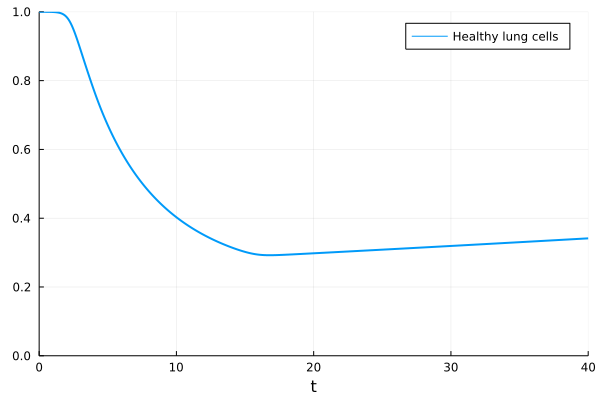

In [5]:
# display
sol = solve(model.prob, Tsit5(), dtmax=1e-1)
plot(sol, labels=model.vars.description[1], lw=2, ylims=(0., 1))

## Survival model

## Simulations

In [6]:
chn = RiskCov19.train(train, model, n_samples=100, n_chains=2)
# save results
# savefig(plot(chn), joinpath("results", model.id*"-figure-chains.png"))
# write(joinpath("results", model.id*"-chains.jls"), chn)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/QRn5N/src/inference/hmc.jl:188


LoadError: MethodError: no method matching lastindex(::Nothing)
[0mClosest candidates are:
[0m  lastindex(::Any, [91m::Any[39m) at abstractarray.jl:348
[0m  lastindex([91m::Union{Tables.AbstractColumns, Tables.AbstractRow}[39m) at /home/shigoto/.julia/packages/Tables/M26tI/src/Tables.jl:178
[0m  lastindex([91m::Union{DataStructures.SortedDict, DataStructures.SortedMultiDict, DataStructures.SortedSet}[39m) at /home/shigoto/.julia/packages/DataStructures/vSp4s/src/tokens2.jl:19
[0m  ...

In [ ]:
# display
display(chn)
plot(chn)

In [8]:
# predict
pred = RiskCov19.predict(test, chn, train, model)
select(insertcols!(data.df, 2, :Prediction => pred), [:Dead, :Prediction])

modelProb (generic function with 3 methods)

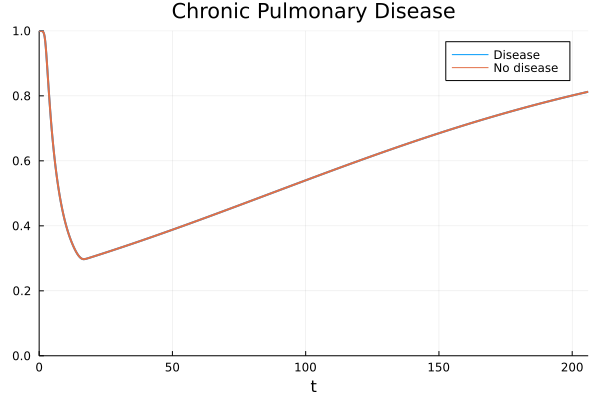

In [24]:
plot(sols[1], label="Disease", lw=2, ylims=(0., 1))
plot!(sols[1], label="No disease", lw=2)
title!("Chronic Pulmonary Disease")

In [34]:
insertcols!(data.df, 2, :Prediction => predict_RiskCov19(data, chns, model_VLF001, data))

,Dead,Prediction,Chronic_Pulmonary_Disease,Time,Male
,Float64,Float64,Int64,Float64,Float64
1,0.0,0.00721903,2,5.0,0.0
2,0.0,0.00671076,2,16.0,0.0
3,0.0,0.00733729,2,25.0,1.0
4,0.0,0.00719742,1,27.0,1.0
5,0.0,0.00693689,2,12.0,0.0
6,1.0,0.00703907,2,10.0,0.0
7,0.0,0.00892136,2,3.0,1.0
8,0.0,0.0082136,2,14.0,1.0
9,0.0,0.00592061,2,46.0,1.0


In [92]:
display("text/markdown", "**Computer Information:**")
vinfo = sprint(InteractiveUtils.versioninfo)
display("text/markdown",  "```$(vinfo)```")

using Pkg
display("text/markdown","**Packages Information:**")
pkgs = ["Turing", 
    "OrdinaryDiffEq", 
    "LinearAlgebra", 
    "QuadGK", 
    "LaTeXStrings", 
    "DelimitedFiles", 
    "DataFrames", 
    "CategoricalArrays"]
Pkg.status(pkgs)

**Computer Information:**

```Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: AMD Ryzen 7 4700U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, znver2)
```

**Packages Information:**

      Status `~/.julia/environments/v1.6/Project.toml`
  [324d7699] CategoricalArrays v0.10.2
  [a93c6f00] DataFrames v1.3.1
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v6.4.1
  [1fd47b50] QuadGK v2.4.2
  [fce5fe82] Turing v0.19.3
